In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
print(X_footsteps_accelerations_absolute.shape)
print(Y_footsteps_accelerations_absolute.shape)

(18641, 21)
(18641, 4)


In [6]:
min(Y_footsteps_accelerations_absolute[:, 0])

-0.36878131235161327

In [7]:
max(Y_footsteps_accelerations_absolute[:, 0])

0.8620843228583086

# Multivariate Linear Regression (Foot prediction)

In [8]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

In [9]:
# Entries where FL is swinging
idxs = np.where(X_footsteps_accelerations_absolute[:, -2] == 1)[0]
X_footsteps_accelerations_absolute_FL_swinging = X_footsteps_accelerations_absolute[idxs]
Y_footsteps_accelerations_absolute_FL_swinging = Y_footsteps_accelerations_absolute[idxs]

In [10]:
len(idxs)

9324

In [11]:
X_footsteps_accelerations_absolute_FL_swinging[0]

array([ 0.1       ,  0.        ,  0.        ,  0.0753413 , -0.03407997,
       -0.01022839,  0.09069058,  0.22756822,  0.12994003, -0.38455901,
        0.25123128, -0.13026568, -0.38243401, -0.24825734,  0.12570569,
       -0.38843367, -0.27167571, -0.12398759, -0.38747641,  1.        ,
        0.        ])

In [12]:
Y_footsteps_accelerations_absolute[0]

array([ 3.76987239e-02, -2.84286750e-03,  3.80168041e-02, -5.36085387e-05])

## Predict FL foot -> x

### Linear Regression

In [13]:
def find_best_model(X, Y, runs=1000):
    best_model = None
    lowest_error = 100
    best_Xtr, best_Xte, best_Ytr, best_Yte = None, None, None, None
    
    for _ in range(runs):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)
        
        model = LinearRegression()
        model.fit(X_train, Y_train)

        predictions = model.predict(X_test)
        error = np.max(np.abs(predictions - Y_test))

        if error < lowest_error:
            best_model = model
            lowest_error = error
            best_Xtr, best_Xte, best_Ytr, best_Yte = X_train, X_test, Y_train, Y_test

    # Stats
    predictions = best_model.predict(best_Xte)
    print('R2: ', r2_score(predictions, best_Yte))
    print('RMSE: ', np.sqrt(mean_squared_error(best_Yte, predictions)))
    print("The lowest error is: ", np.min(np.abs(predictions - best_Yte)))
    print("The highest error is: ", np.max(np.abs(predictions - best_Yte)))
    print("The avg. error is: ", np.mean(np.abs(predictions - best_Yte)))
    
    return best_Xte, best_Yte, predictions, best_model

In [14]:
X_footsteps_accelerations_absolute_FL_swinging[0, :]

array([ 0.1       ,  0.        ,  0.        ,  0.0753413 , -0.03407997,
       -0.01022839,  0.09069058,  0.22756822,  0.12994003, -0.38455901,
        0.25123128, -0.13026568, -0.38243401, -0.24825734,  0.12570569,
       -0.38843367, -0.27167571, -0.12398759, -0.38747641,  1.        ,
        0.        ])

In [15]:
# Input
X = np.hstack((X_footsteps_accelerations_absolute_FL_swinging[:, 0:1], # current reference velocity
               X_footsteps_accelerations_absolute_FL_swinging[:, 3:4], # actual velocity
               X_footsteps_accelerations_absolute_FL_swinging[:, 7:9], # FL position
               X_footsteps_accelerations_absolute_FL_swinging[:, 10:12], # FR position
               X_footsteps_accelerations_absolute_FL_swinging[:, 13:15], # RL position
               X_footsteps_accelerations_absolute_FL_swinging[:, 16:18])) # RR position

# Labels
Y = np.array([Y_footsteps_accelerations_absolute_FL_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fl_relative_support_x = find_best_model(X, Y, runs=5000)

R2:  0.9891231777662866
RMSE:  0.022732223742593965
The lowest error is:  5.8631206514753176e-05
The highest error is:  0.08169466456444696
The avg. error is:  0.017043238374480615


In [16]:
model_fl_relative_support_x.coef_

array([[ 0.09527837,  0.62307263, -0.48934844, -0.1312738 , -1.90407128,
         1.37103624,  0.11439445,  0.48734909, -0.69368284, -0.68833573]])

In [17]:
model_fl_relative_support_x.intercept_

array([0.47322866])

In [18]:
#inp = np.array([[0.9, 0.661, 0.159, 0.124, 0.331, -0.137, -0.169, 0.119, -0.337, -0.127]])

In [19]:
#out = model_fl_relative_support_x.coef_ @ inp.T
#out += model_fl_relative_support_x.intercept_
#print(out)

Text(0, 0.5, 'Predictions')

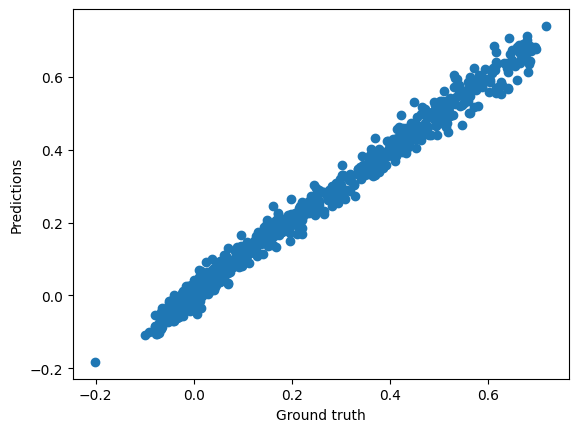

In [20]:
# The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [21]:
#for idx, prediction in enumerate(predictions):
#    print(f'{X_test[idx, 0]} -> {X_test[idx, 1]}. CoM: {X_test[idx, 2]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}.')

### Predict FL foot -> y

In [22]:
# Input
X = np.hstack((X_footsteps_accelerations_absolute_FL_swinging[:, 0:1], # current reference velocity
               X_footsteps_accelerations_absolute_FL_swinging[:, 3:4], # actual velocity
               X_footsteps_accelerations_absolute_FL_swinging[:, 7:9], # FL position
               X_footsteps_accelerations_absolute_FL_swinging[:, 10:12], # FR position
               X_footsteps_accelerations_absolute_FL_swinging[:, 13:15], # RL position
               X_footsteps_accelerations_absolute_FL_swinging[:, 16:18])) # RR position

# Labels
Y = np.array([Y_footsteps_accelerations_absolute_FL_swinging[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fl_relative_support_y = find_best_model(X, Y, runs=5000)

R2:  0.9183775204535978
RMSE:  0.00943059513768983
The lowest error is:  1.6473102362728892e-06
The highest error is:  0.031510553507301406
The avg. error is:  0.007089342682978723


In [23]:
model_fl_relative_support_y.coef_

array([[-0.0081548 ,  0.12739258,  0.30876009, -1.71355152, -0.07925677,
         0.63989057, -0.56430549,  0.30499927, -0.32142618, -0.36211739]])

In [24]:
model_fl_relative_support_y.intercept_

array([-0.0671177])

Text(0, 0.5, 'Predictions')

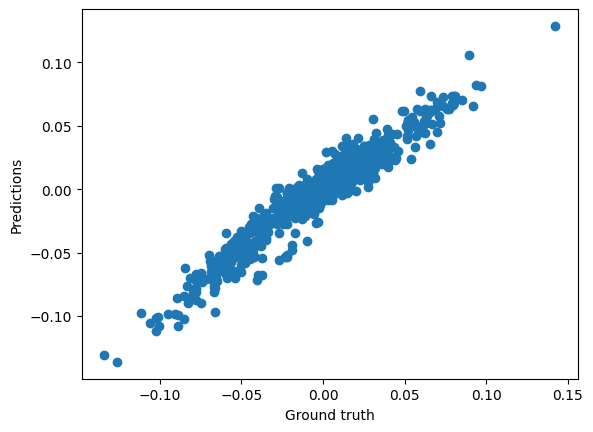

In [25]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [26]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')